## Quantum Shift: Interactive Text Data Visualization

In [29]:
!pip install wordcloud

  Using cached wordcloud-1.9.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.4 kB)
Using cached wordcloud-1.9.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (511 kB)


In [30]:
import numpy as np
import math
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def create_vocabulary(sentences):
    vocabulary_set = set()
    for sentence in sentences:
        words = sentence.split()
        vocabulary_set.update(words)
    vocabulary = list(vocabulary_set)
    return vocabulary

def one_hot_encode(word, vocabulary):
    one_hot_vector = [0] * len(vocabulary)
    if word in vocabulary:
        index = vocabulary.index(word)
        one_hot_vector[index] = 1
    return one_hot_vector

def sentence_to_one_hot(sentence, vocabulary):
    one_hot_vectors = []
    for word in sentence.split():
        one_hot_vector = one_hot_encode(word, vocabulary)
        one_hot_vectors.append(one_hot_vector)
    return one_hot_vectors

sentences = ["He hate me", "She loves coding", "Programming is fun"]

vocabulary = create_vocabulary(sentences)

result = []
for sentence in sentences:
    result.append(sentence_to_one_hot(sentence, vocabulary))

In [3]:
flattened_sentences = [item for sublist in result for item in sublist]
binary_strings = [''.join(map(str, vector)) for vector in flattened_sentences]

print(binary_strings)

['010000000', '000000010', '000001000', '000100000', '000000001', '100000000', '000000100', '000010000', '001000000']


In [4]:
# Create a dictionary
binary_to_word_dict = dict(zip(binary_strings, vocabulary))
print(binary_to_word_dict)

{'010000000': 'coding', '000000010': 'He', '000001000': 'fun', '000100000': 'She', '000000001': 'is', '100000000': 'me', '000000100': 'Programming', '000010000': 'hate', '001000000': 'loves'}


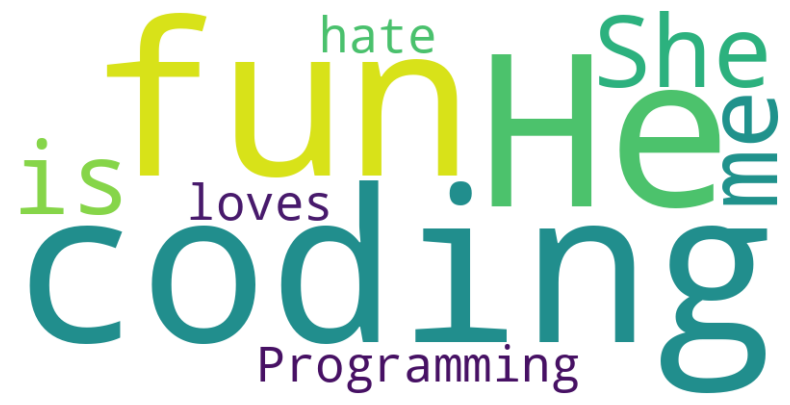

In [5]:
from wordcloud import WordCloud
word_frequencies = {word: list(binary_to_word_dict.values()).count(word) for word in set(binary_to_word_dict.values())}

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate_from_frequencies(word_frequencies)


plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig('words.png')
plt.show()

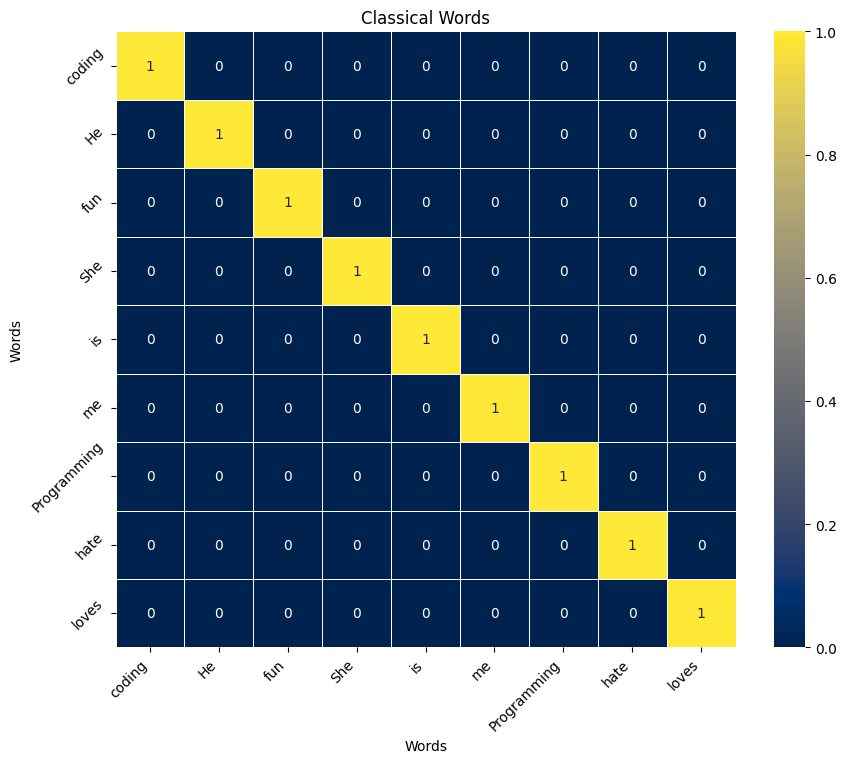

In [6]:
df = pd.DataFrame(0, index=binary_to_word_dict.values(), columns=binary_to_word_dict.values())

for word in binary_to_word_dict.values():
    df.loc[word, word] = 1

plt.figure(figsize=(10, 8))

heatmap = sns.heatmap(df, annot=True, cmap='cividis', linewidths=.5)

# Rotate x-axis labels by 45 degrees
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, ha='right')

# Rotate y-axis labels by 45 degrees
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=45)

plt.xlabel('Words')
plt.ylabel('Words')
plt.title('Classical Words')
plt.savefig('onehot.png')
# Show the plot
plt.show()

In [7]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
from qiskit.visualization import plot_distribution

In [8]:
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Batch

In [9]:
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.backend("ibmq_qasm_simulator")

qiskit_runtime_service.__init__:INFO:2024-04-18 15:05:20,454: Default instance: ibm-q-education/florida-tech-1/fit-ece-5570


In [10]:
def grover_oracle(marked_states):
    if not isinstance(marked_states, list):
        marked_states = [marked_states]
        
    num_qubits = len(marked_states[0])

    qc = QuantumCircuit(num_qubits)
    for target in marked_states:
        rev_target = target[::-1]
        zero_inds = [ind for ind in range(num_qubits) if rev_target.startswith("0", ind)]
 
        qc.x(zero_inds)
        qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)
        qc.x(zero_inds)
    return qc

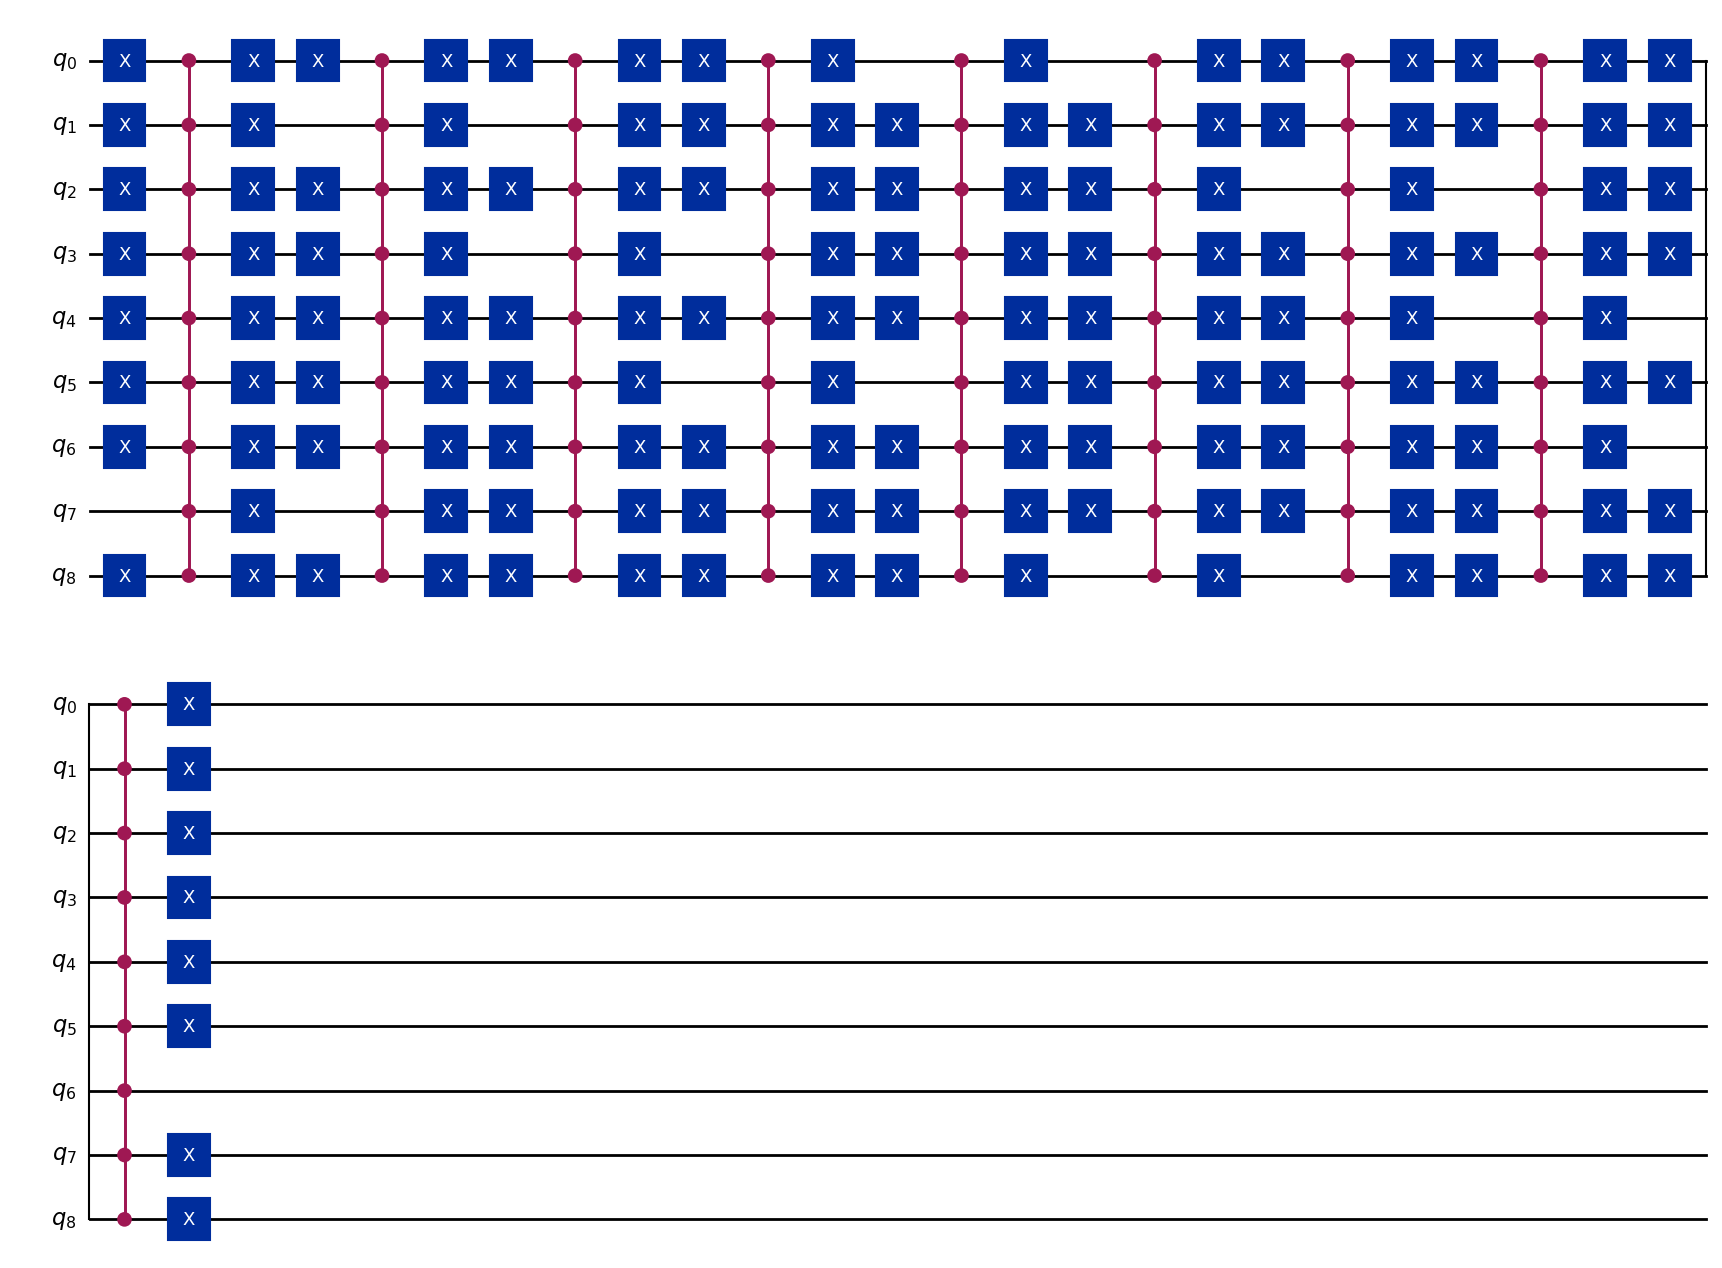

In [11]:
oracle = grover_oracle(binary_strings)
oracle.draw(output="mpl", style="iqp")

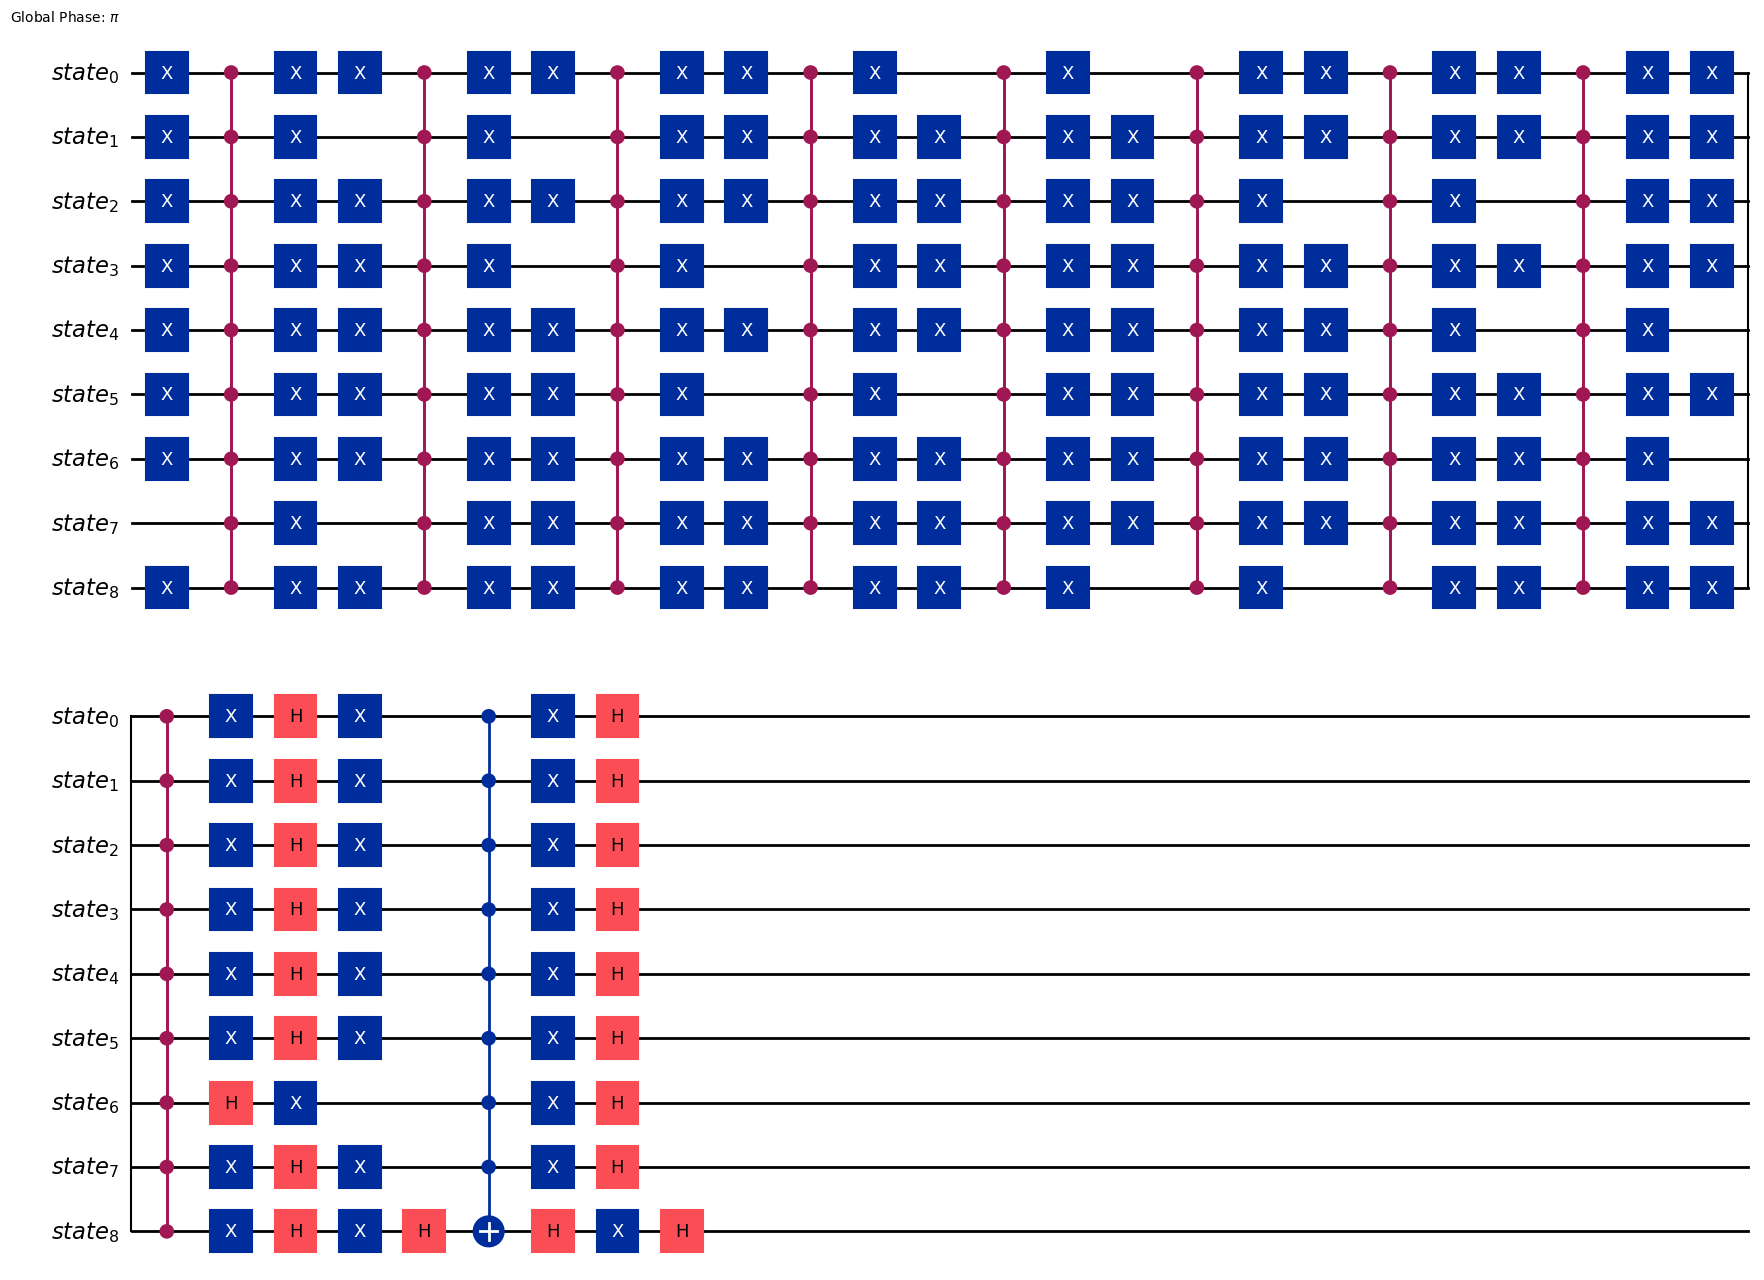

In [12]:
grover_op = GroverOperator(oracle)
grover_op.decompose().draw(output="mpl", style="iqp")

In [13]:
optimal_num_iterations = math.floor(
    math.pi / (4 * math.asin(math.sqrt(len(binary_strings) / 2**grover_op.num_qubits)))
)

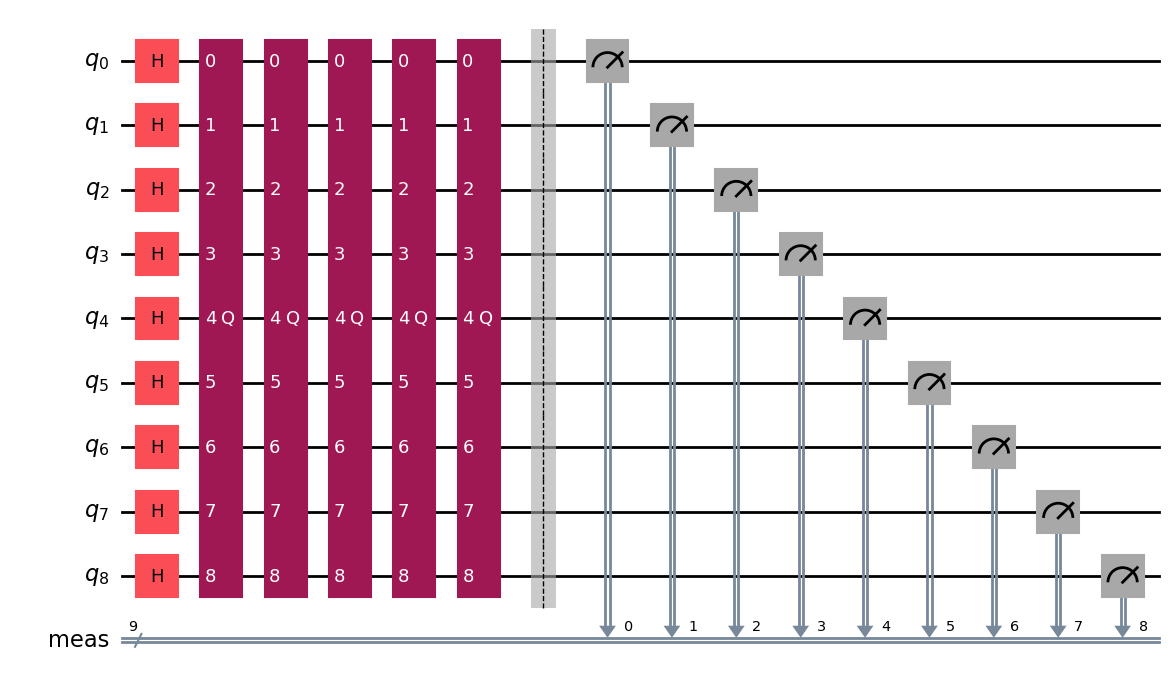

In [14]:
qc = QuantumCircuit(grover_op.num_qubits)
qc.h(range(grover_op.num_qubits))
qc.compose(grover_op.power(optimal_num_iterations), inplace=True)
qc.measure_all()
qc.draw(output="mpl", style="iqp")

In [15]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=1)

circuit_ibm = pm.run(qc)
#circuit_ibm.draw(output="mpl", idle_wires=False, style="iqp")

In [16]:
with Batch(backend=backend) as batch:
    sampler = Sampler()
    dist = sampler.run(circuit_ibm, skip_transpilation=False, shots=100).result().quasi_dists[0]
dist.binary_probabilities()

base_primitive._run_primitive:INFO:2024-04-18 15:05:36,934: Submitting job using options {'optimization_level': 1, 'resilience_level': 0, 'transpilation': {'skip_transpilation': False, 'optimization_settings': {'level': 1}}, 'resilience': {'level': 0}, 'execution': {'shots': 100, 'init_qubits': True}, 'environment': {'log_level': 'WARNING'}, 'simulator': {'noise_model': Unset, 'seed_simulator': Unset, 'coupling_map': Unset, 'basis_gates': Unset}}
qiskit_runtime_service.run:INFO:2024-04-18 15:05:36,935: Instance selected: ibm-q/open/main


{'110001010': 0.01,
 '010101001': 0.01,
 '111101101': 0.01,
 '001000000': 0.08,
 '000100000': 0.08,
 '000000010': 0.11,
 '100000000': 0.1,
 '000010000': 0.09,
 '000001000': 0.07,
 '000000100': 0.19,
 '000000001': 0.12,
 '010000000': 0.13}

In [17]:
binary_dict = dist.binary_probabilities()

In [18]:
binary_dict

{'110001010': 0.01,
 '010101001': 0.01,
 '111101101': 0.01,
 '001000000': 0.08,
 '000100000': 0.08,
 '000000010': 0.11,
 '100000000': 0.1,
 '000010000': 0.09,
 '000001000': 0.07,
 '000000100': 0.19,
 '000000001': 0.12,
 '010000000': 0.13}

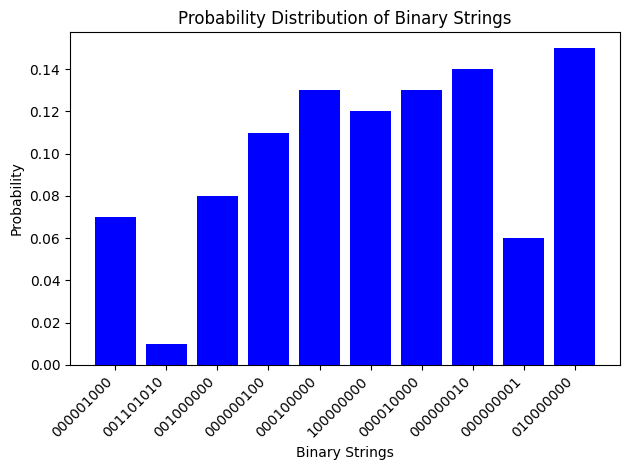

In [19]:
import matplotlib.pyplot as plt

# Given probability distribution
probability_distribution = {
    '000001000': 0.07,
    '001101010': 0.01,
    '001000000': 0.08,
    '000000100': 0.11,
    '000100000': 0.13,
    '100000000': 0.12,
    '000010000': 0.13,
    '000000010': 0.14,
    '000000001': 0.06,
    '010000000': 0.15
}

# Extracting binary strings and corresponding probabilities
binary_strings = list(probability_distribution.keys())
probabilities = list(probability_distribution.values())

# Creating a bar chart
plt.bar(binary_strings, probabilities, color='blue')
plt.xlabel('Binary Strings')
plt.ylabel('Probability')
plt.title('Probability Distribution of Binary Strings')
plt.xticks(rotation=45, ha='right')  # Rotating x-axis labels for better visibility
plt.tight_layout()

# Display the plot
plt.savefig('probability.png')
plt.show()

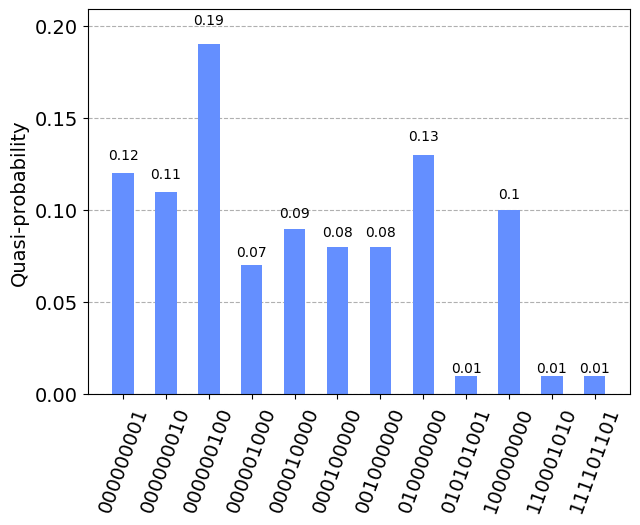

In [20]:
plot_distribution(binary_dict)

In [21]:
def get_values_for_present_keys(input_dict, output_dict):
    input_keys = set(input_dict.keys())
    output_keys = set(output_dict.keys())
    common_keys = input_keys.intersection(output_keys)
    values_for_common_keys = {key: input_dict[key] for key in common_keys}
    return values_for_common_keys

In [22]:
result = get_values_for_present_keys(binary_to_word_dict, binary_dict)
result

{'000000010': 'He',
 '000000001': 'is',
 '001000000': 'loves',
 '000001000': 'fun',
 '010000000': 'coding',
 '000010000': 'hate',
 '000000100': 'Programming',
 '000100000': 'She',
 '100000000': 'me'}

In [23]:
def visualize_word_cloud(values_dict):
    # Convert values_dict to a frequency dictionary
    frequencies = {word: int(freq * 100) for word, freq in values_dict.items()}

    # Generate a word cloud from the frequencies
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(frequencies)

    # Plot the Word Cloud image
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Input Values')
    plt.show()

In [24]:
def visualize_word_cloud_bit(values_dict):
    # Count occurrences of each word
    frequencies = {}
    for word, value in values_dict.items():
        if value in frequencies:
            frequencies[word] += 1
        else:
            frequencies[word] = 1

    # Generate WordCloud from frequencies
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(frequencies)

    # Plot the Word Cloud image
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Binary values from Quantum Output')
    plt.savefig('Binary.png')
    plt.show()

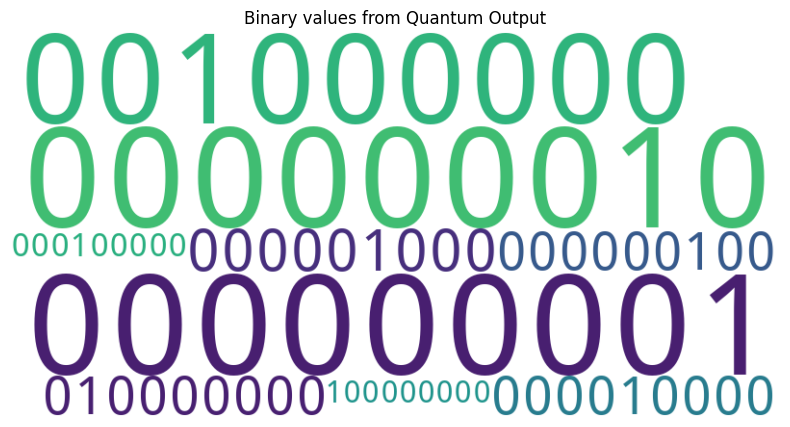

In [25]:
visualize_word_cloud_bit(result)

In [26]:
words = []
for i in result.values():
    words.append(i)
    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


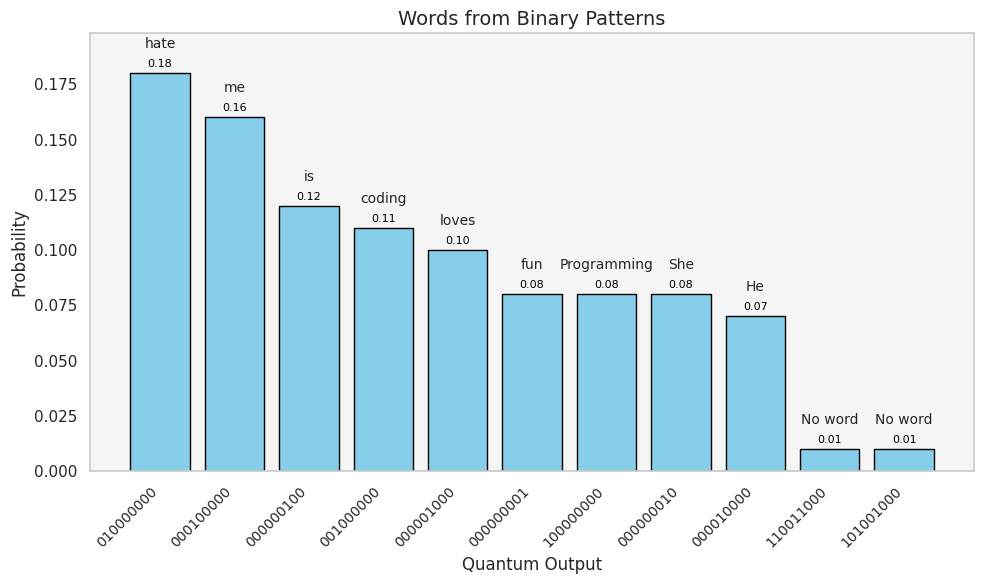

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

data = {'110011000': 0.01,
        '101001000': 0.01,
        '001000000': 0.11,
        '000100000': 0.16,
        '000000001': 0.08,
        '010000000': 0.18,
        '100000000': 0.08,
        '000010000': 0.07,
        '000000010': 0.08,
        '000001000': 0.1,
        '000000100': 0.12}

word_mapping = {'100000000': 'Programming',
                '000001000': 'loves',
                '001000000': 'coding',
                '000010000': 'He',
                '000000001': 'fun',
                '000100000': 'me',
                '010000000': 'hate',
                '000000010': 'She',
                '000000100': 'is'}

# Sorting data by values
sorted_data = sorted(data.items(), key=lambda x: x[1], reverse=True)

# Extracting binary patterns and their corresponding values
patterns, values = zip(*sorted_data)

# Set seaborn style
sns.set(style="whitegrid")

# Create a bar plot
fig, ax2 = plt.subplots(figsize=(10, 6))

# Plot individual probabilities with aesthetic view
bars = ax2.bar(patterns, values, color='skyblue', edgecolor='black')

# Add marks and lines on top of each bar
for bar, pattern, value in zip(bars, patterns, values):
    ax2.annotate(f'{value:.2f}', xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                 xytext=(0, 3),  # 3 points vertical offset
                 textcoords="offset points", ha='center', va='bottom', fontsize=8, color='black')
    ax2.plot([bar.get_x(), bar.get_x() + bar.get_width()], [bar.get_height(), bar.get_height()],
             color='black', linestyle='-', linewidth=0.5)

# Add words labels at the top of each bar
for bar, pattern in zip(bars, patterns):
    word_label = word_mapping.get(pattern, 'No word')
    ax2.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, word_label, ha='center', va='bottom', fontsize=10)

ax2.set_xlabel('Quantum Output', fontsize=12)
ax2.set_ylabel('Probability', fontsize=12)
ax2.set_title('Words from Binary Patterns', fontsize=14)

# Rotate x-axis labels
ax2.set_xticklabels(patterns, rotation=45, ha='right', fontsize=10)

# Remove grid
ax2.grid(False)

# Remove legend
ax2.legend().remove()

# Adjust margins
plt.margins(y=0.1)

# Add horizontal line at y=0
ax2.axhline(0, color='black', linewidth=0.5)

# Add background color
ax2.set_facecolor('#f5f5f5')

plt.tight_layout()
plt.savefig('output.png', dpi=300)  # Save the plot with higher resolution
plt.show()

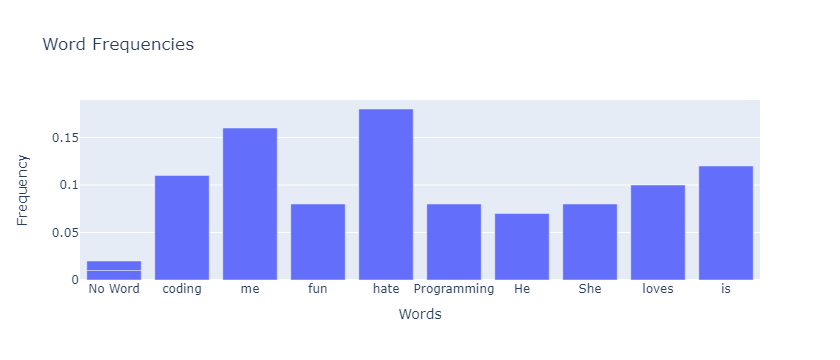

In [40]:
import plotly.graph_objects as go

# Define the data
words_data = {'110011000': 0.01,
              '101001000': 0.01,
              '001000000': 0.11,
              '000100000': 0.16,
              '000000001': 0.08,
              '010000000': 0.18,
              '100000000': 0.08,
              '000010000': 0.07,
              '000000010': 0.08,
              '000001000': 0.1,
              '000000100': 0.12}

word_mapping = {'100000000': 'Programming',
                '000001000': 'loves',
                '001000000': 'coding',
                '000010000': 'He',
                '000000001': 'fun',
                '000100000': 'me',
                '010000000': 'hate',
                '000000010': 'She',
                '000000100': 'is'}

# Map word codes to actual words
words = [word_mapping.get(code, 'No Word') for code in words_data.keys()]
frequencies = list(words_data.values())

# Create the bar chart
fig = go.Figure([go.Bar(x=words, y=frequencies)])

# Update layout for better readability
fig.update_layout(title_text='Word Frequencies',
                  xaxis_title='Words',
                  yaxis_title='Frequency')

fig.show()

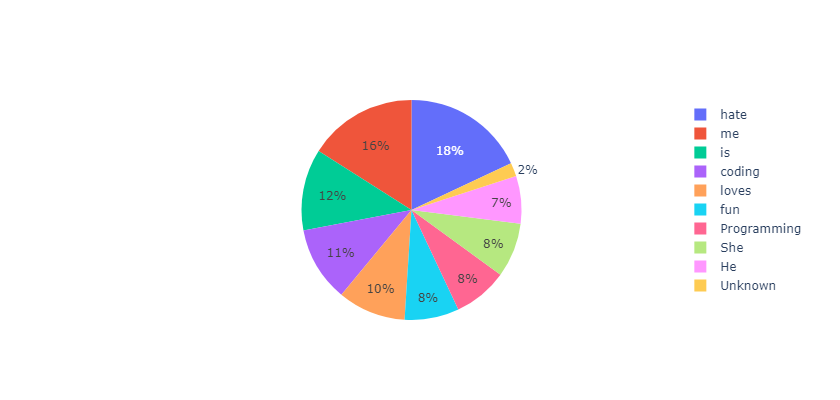

In [50]:
import plotly.graph_objects as go

# Define the data
words_data = {'110011000': 0.01,
              '101001000': 0.01,
              '001000000': 0.11,
              '000100000': 0.16,
              '000000001': 0.08,
              '010000000': 0.18,
              '100000000': 0.08,
              '000010000': 0.07,
              '000000010': 0.08,
              '000001000': 0.1,
              '000000100': 0.12}

word_mapping = {'100000000': 'Programming',
                '000001000': 'loves',
                '001000000': 'coding',
                '000010000': 'He',
                '000000001': 'fun',
                '000100000': 'me',
                '010000000': 'hate',
                '000000010': 'She',
                '000000100': 'is'}

# Map word codes to actual words
words = []
for code in words_data.keys():
    if code in word_mapping:
        words.append(word_mapping[code])
    else:
        words.append('Unknown')

frequencies = list(words_data.values())

# Create the pie chart
fig = go.Figure(data=[go.Pie(labels=words, values=frequencies)])

# Update layout for better readability and reduced size
fig.update_layout(height=400, width=500)

# Show the interactive graph
fig.show()


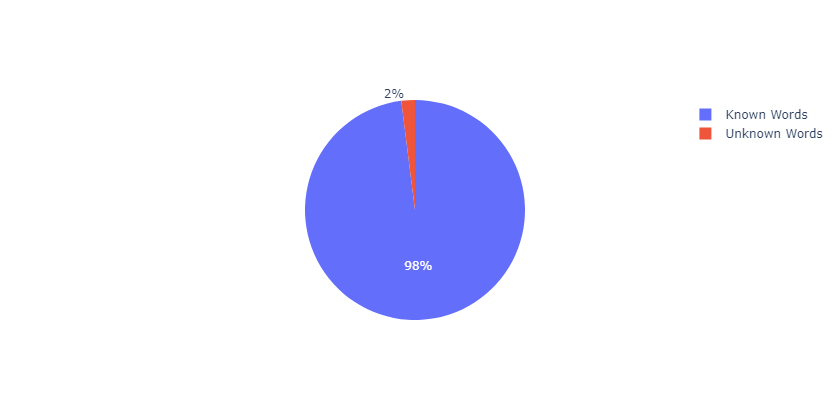

In [4]:
import plotly.graph_objects as go

# Define the data
known_words_frequency = sum(words_data.get(code, 0) for code in word_mapping)
unknown_words_frequency = 1 - known_words_frequency

# Create the pie chart
fig = go.Figure(data=[go.Pie(labels=['Known Words', 'Unknown Words'], 
                             values=[known_words_frequency, unknown_words_frequency])])

# Update layout for better readability and reduced size
fig.update_layout(height=400, width=500)

# Show the interactive graph
fig.show()

In [31]:
sorted_words_data = sorted(words_data.items(), key=lambda x: x[1], reverse=True)

correlated_words = []
for word_key, _ in sorted_words_data:
    if word_key in word_mapping:
        correlated_words.append(word_mapping[word_key])

print("Correlated Words based on Probabilities:")
print(correlated_words)

Correlated Words based on Probabilities:
['hate', 'me', 'is', 'coding', 'loves', 'fun', 'Programming', 'She', 'He']


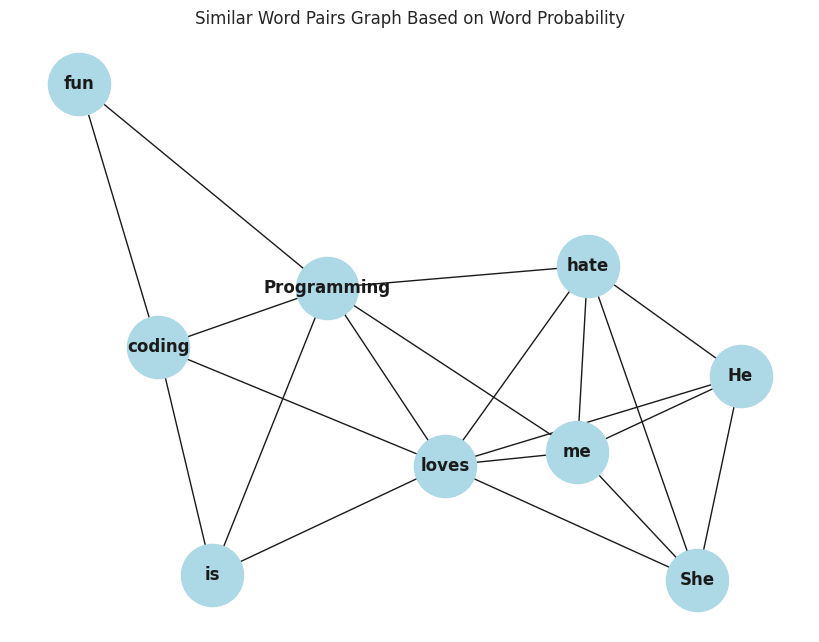

In [75]:
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations

# Define word list
word_list = ['hate', 'me', 'is', 'coding', 'loves', 'fun', 'Programming', 'She', 'He']

# Define similarity threshold
similarity_threshold = 0.01  # Adjust this value as needed

# Function to compute similarity between two words
def compute_similarity(word1, word2):
    intersection = len(set(word1) & set(word2))
    union = len(set(word1) | set(word2))
    return intersection / union

# Create graph
G = nx.Graph()

# Add nodes
G.add_nodes_from(word_list)

# Add edges based on similarity
for pair in combinations(word_list, 2):
    word1, word2 = pair
    similarity = compute_similarity(word1, word2)
    if similarity > similarity_threshold:
        G.add_edge(word1, word2)

# Plot the graph
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_size=2000, node_color='lightblue', font_weight='bold')
plt.title("Similar Word Pairs Graph Based on Word Probability")
plt.savefig('wordpair.png', dpi=300)
plt.show()
